# 1. Importing Packages and loading Dataset
   ##### First we import packages that are needed for loading dataset, preprocessing, then we can load the dataset of a subject 'X' , X can vary from 0-35, we have a total 36 patients.

In [1]:
import os
import numpy as np
from pyod.models import hbos
from pyod.utils.data import evaluate_print
from sklearn.metrics import confusion_matrix,cohen_kappa_score,f1_score
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import pandas as pd


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
#####
# Trial or epoch = eeg segment
#####

channels = 32
seconds = 0.5    # Size of each segment we want
fs = 256.0         # Dataset eeg sampling rate
data_portion = 1
save_model = False



##### In this cell, we import and load our dataset, since the data present has no labels, we assign labels by using a alternate method of read_csv of Pandas, names argument in pandas.read_csv('file_name', names=[]) is used to specify the column names for the DataFrame being created from the CSV file.
##### Syntax: 
### pandas.read_csv('file_name',names=['col_name1','col_name2','col_name3',''.....])

In [4]:
df1 = pd.read_csv(r"C:\Users\KIIT\Desktop\Minor Project\CompEEG\new db\s02.csv",names=['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'T3','T4', 'C3', 'C4', 'T5', 'T6','P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz'])
df1.head()

,Fp1,Fp2,F3,F4,F7,F8,T3,T4,C3,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
0,3.52580,0.71455,7.2127,4.1612,3.9060,1.5571,9.1457,0.99729,12.283,6.1739,1.75600,-2.95650,0.87979,-0.76166,-2.2799,-10.4630,9.5965,6.3301,0.92747
1,2.57740,1.41600,8.3481,5.0625,2.7146,4.6606,8.7752,3.30140,12.397,7.1954,0.96251,-1.42180,0.62475,0.49798,-2.3723,-9.2893,10.4830,7.2550,1.52050
2,0.95841,1.89890,9.8564,5.8947,1.9372,7.9046,8.7209,6.05460,12.818,8.2062,-0.19493,0.32385,0.65744,1.97160,-2.5090,-7.5553,11.6420,8.4885,2.53920
3,-0.97584,2.04580,11.5260,6.5517,1.9137,10.8420,9.2095,8.91530,13.657,9.0716,-1.46590,2.13100,1.27870,3.57080,-2.4202,-5.1478,12.9690,9.9458,4.09640
4,-2.58410,1.84570,13.0400,6.9968,2.8063,13.2970,10.3520,11.55000,14.914,9.7010,-2.53440,3.89410,2.71610,5.25410,-1.7151,-1.9852,14.2750,11.4830,6.22890


#### We can Plot the signals of different electrods below for visualization and check for outlines,missing values.

Text(0.5, 1.0, 'Visualization of Electrode Fp1')

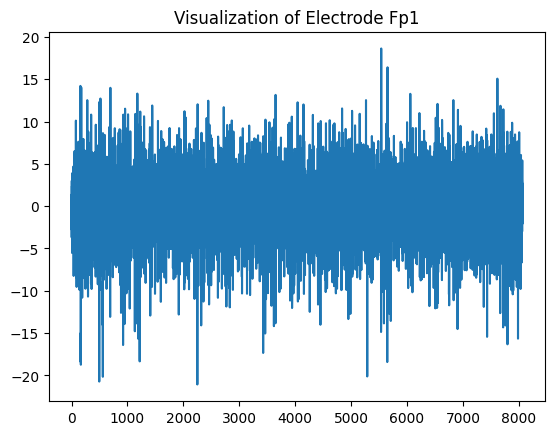

In [5]:
plt.plot(df['Fp1'])
plt.title("Visualization of Electrode Fp1")

Text(0.5, 1.0, 'Visualization of Electrode Fp1')

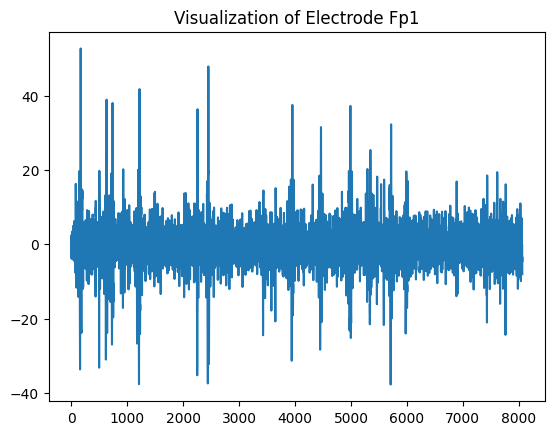

In [6]:
plt.plot(df['Fp2'])
plt.title("Visualization of Electrode Fp1")

Text(0.5, 1.0, 'Visualization of Electrode Fp1')

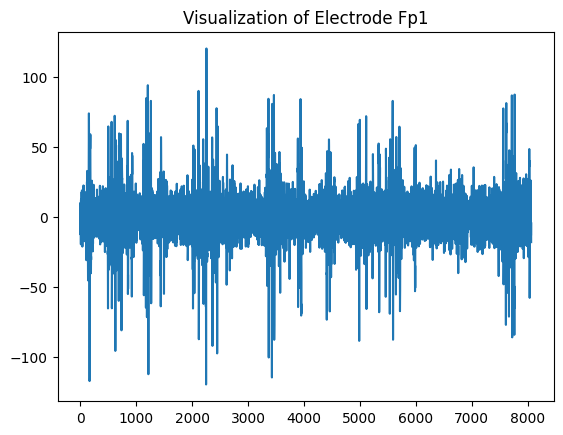

In [7]:
plt.plot(df['F7'])
plt.title("Visualization of Electrode Fp1")

In [8]:
class EEGDataset2:
    def __init__(self, train_csv, seconds=0.500, fs=256, data_portion=1, normalize=True, isolated_channels=False):
        assert data_portion > 0.0 and data_portion <= 1, 'data_portion should be > 0 and <= 1'
        
        self.isolated_channels = isolated_channels
        self.normalize = normalize
        self.train_csv = train_csv
        self.seconds = seconds
        self.fs = fs
        self.data_portion = data_portion
    
    def get_data(self):
        df = pd.read_csv(self.train_csv)
        array_size = int(self.seconds * self.fs)
        # Dataset shape is: [data x channels]
        # we want shape: [segments x features]
        
        if self.normalize:
            df = (df - df.mean()) / df.std()
        
        if self.isolated_channels:
            channels = []
            for channel in df.columns[0:32]:
                isolated_channel = []
                for i in range(int(len(df) / array_size)):
                    isolated_channel.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                channels.append(np.array(isolated_channel))
            return np.array(channels)
            
        dataset = []
        
        for channel in df.columns[0:32]:
            for i in range(int(len(df) / array_size)):
                dataset.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                
        return np.array(dataset)

In [9]:
train_csv = r'C:\Users\KIIT\Desktop\Minor Project\CompEEG\new db\s02.csv'
eegDataset = EEGDataset2(train_csv, seconds, fs, data_portion, normalize=True)

train_dataset = eegDataset.get_data()

In [10]:
train_dataset.shape

(4598, 128)

In [11]:
clf = hbos.HBOS(n_bins=17, alpha=0.07, tol=0.5,contamination=.15)
clf.fit(train_dataset)

HBOS(alpha=0.07, contamination=0.15, n_bins=17, tol=0.5)

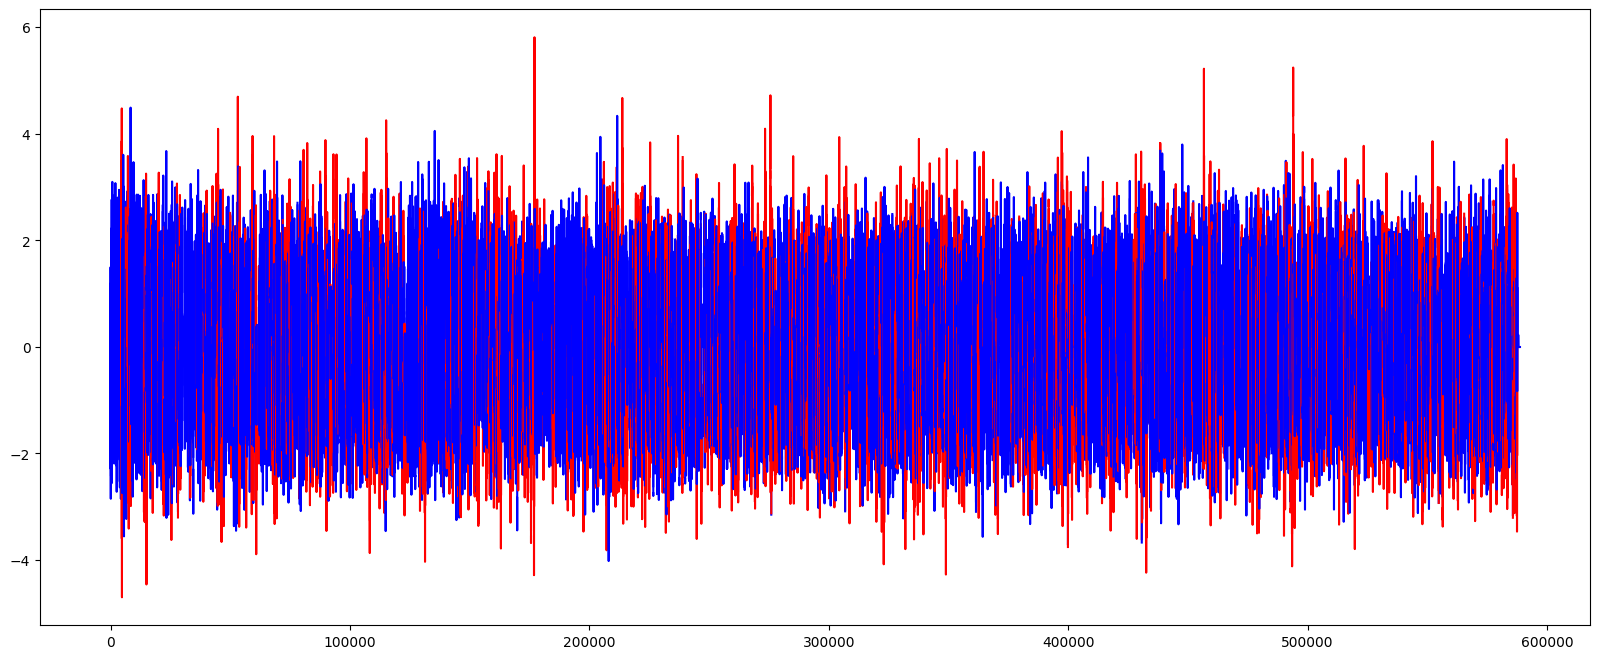

In [12]:
pred = clf.predict(train_dataset)

for i in range(len(pred)):    
    plt.rcParams["figure.figsize"] = (20,8)
    
    if pred[i] == 1: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='red')
    else: plt.plot(range(128*i,128*(i+1)), train_dataset[i], color='b')

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#importing Libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()
# from sklearn.metrics import plot_confusion_matrix
from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [14]:
dataem = pd.read_csv(r"C:\Users\KIIT\Desktop\Minor Project\CompEEG\new db\emotions.csv")

In [15]:
len(dataem)

2132

In [16]:
pos = dataem.loc[dataem["label"]=="POSITIVE"]
sample_pos = pos.loc[2, 'fft_0_b':'fft_749_b']

neg = dataem.loc[dataem["label"]=="NEGATIVE"]
sample_neg = neg.loc[0, 'fft_0_b':'fft_749_b']

neu = dataem.loc[dataem["label"]=="NEUTRAL"]
sample_neu = neu.loc[1, 'fft_0_b':'fft_749_b']

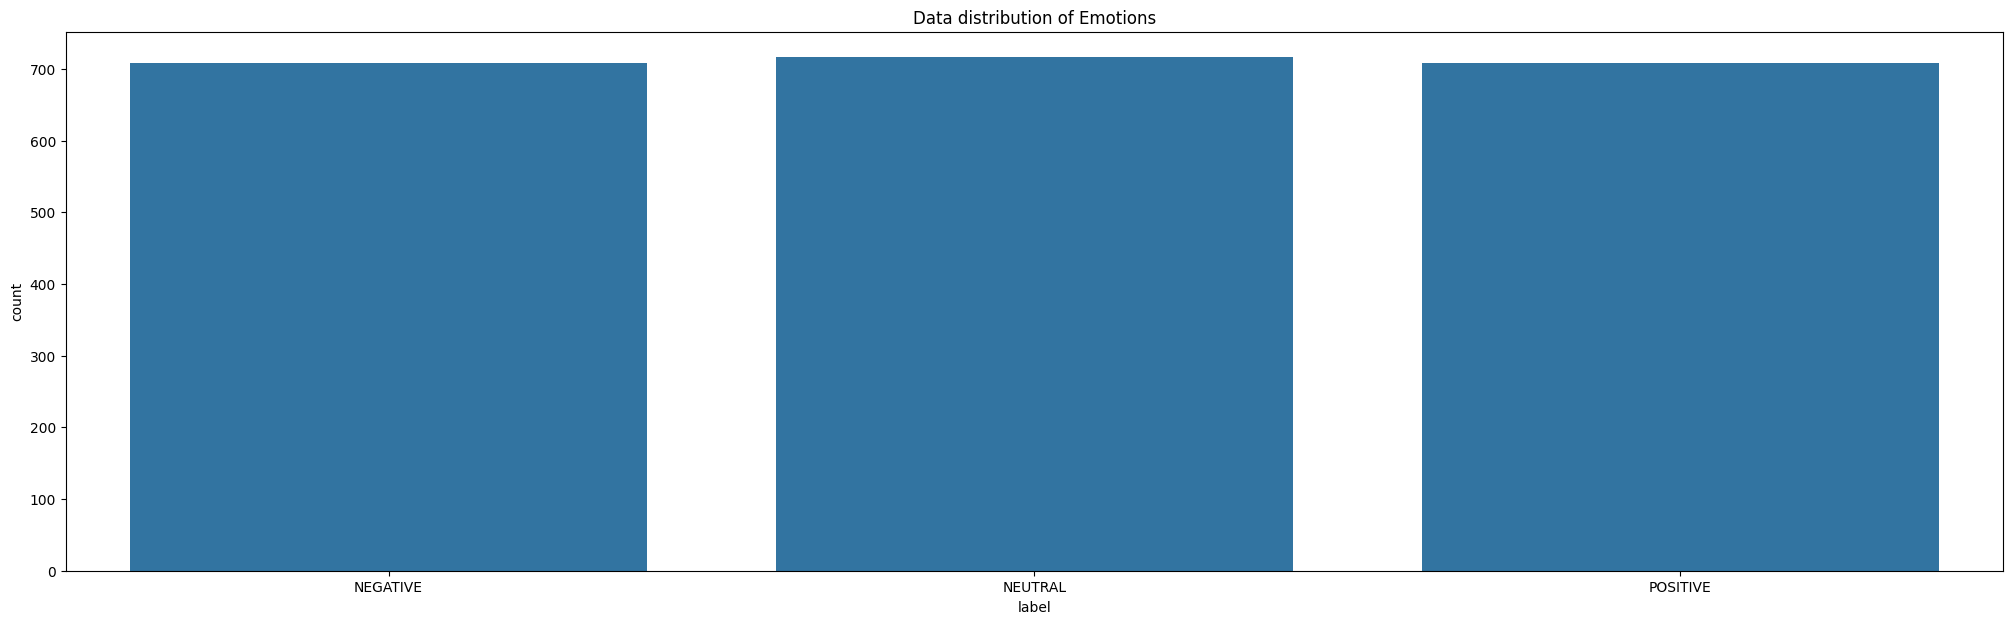

In [17]:
#plottintg Dataframe distribution
plt.figure(figsize=(25,7))
plt.title("Data distribution of Emotions")
plt.style.use('fivethirtyeight')
sns.countplot(x='label', data=dataem)
plt.show()

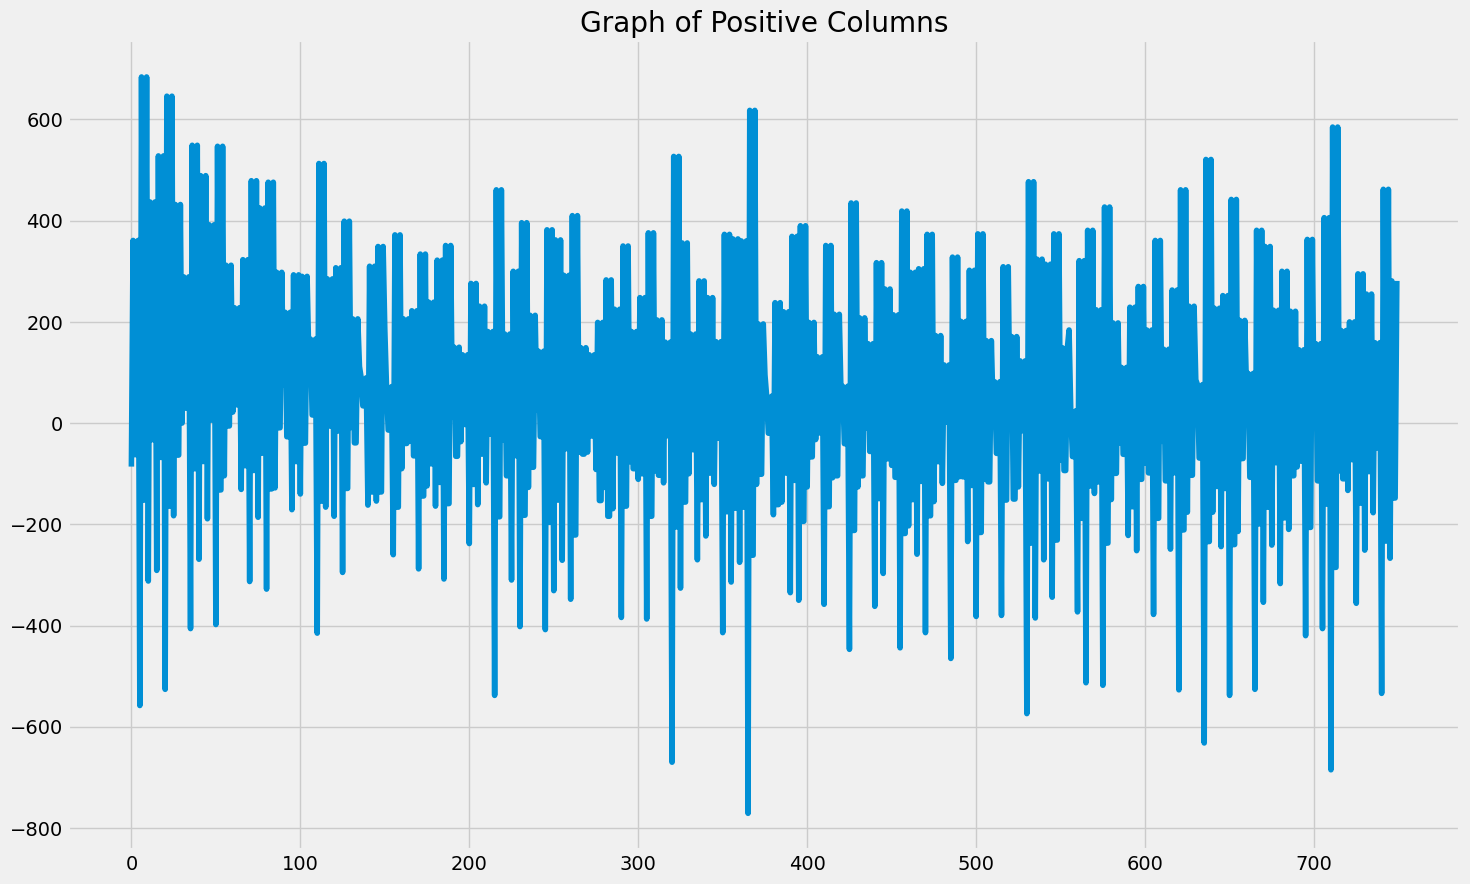

'As we can noticed the most of the Negative Signals are from greater than 600 to and less than than -600'

In [18]:
# Plotting Positive DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_pos)), sample_pos)
plt.title("Graph of Positive Columns")
plt.show()
'''As we can noticed the most of the Negative Signals are from greater than 600 to and less than than -600'''

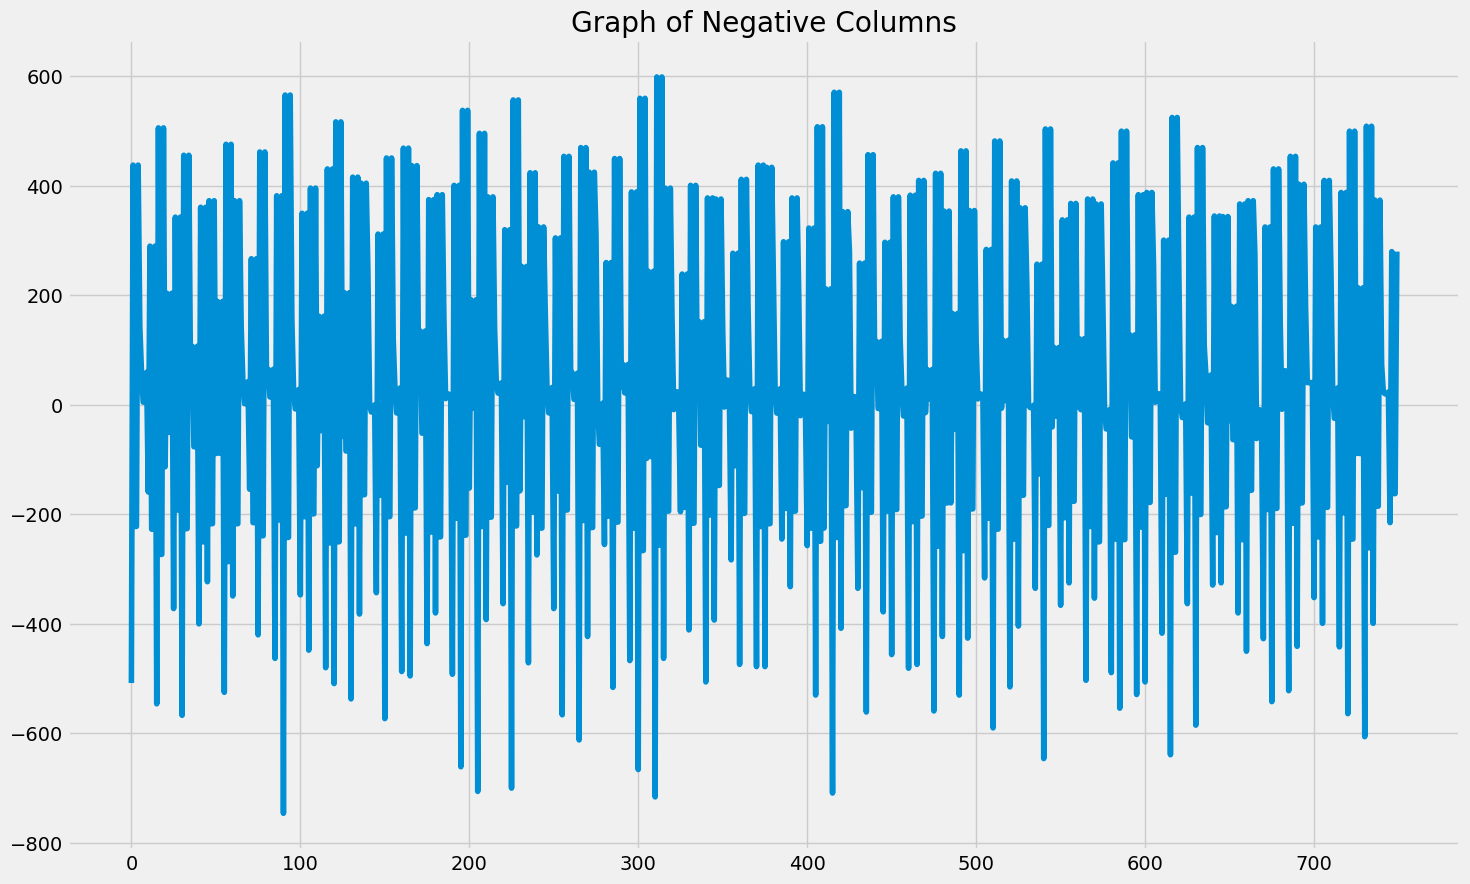

'As we can noticed the most of the Negative Signals are from less than 600 to and greater than -600'

In [19]:
#Plotting Negative DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neg)), sample_neg)
plt.title("Graph of Negative Columns")
plt.show()
'''As we can noticed the most of the Negative Signals are from less than 600 to and greater than -600'''

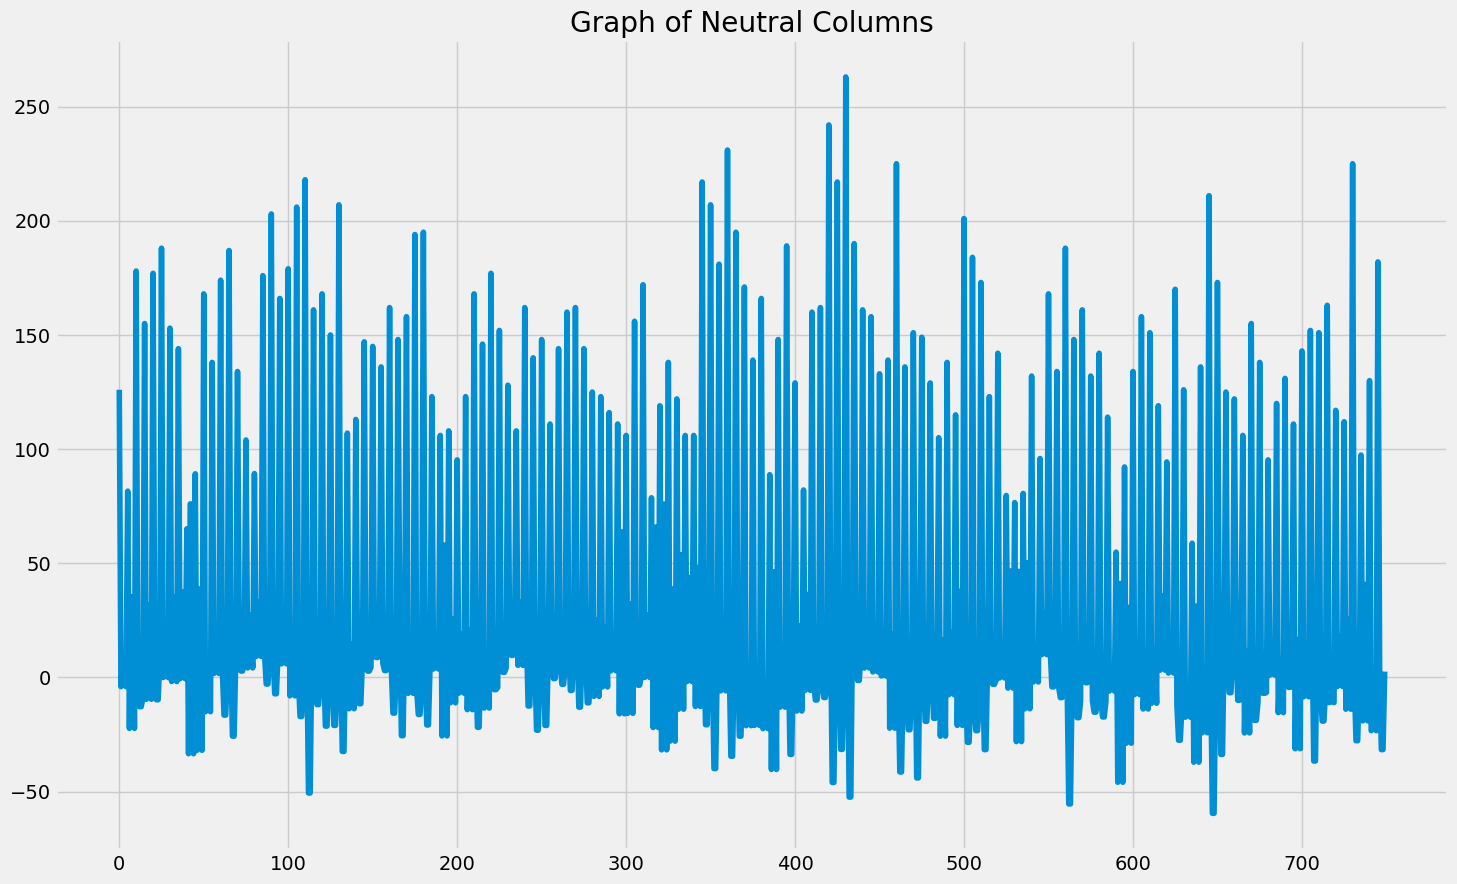

'As we can see the most of the Neutral Signals ae in between -50 to 250 '

In [20]:
#Plotting Neutral DataFrame
plt.figure(figsize=(16, 10))
plt.plot(range(len(sample_neu)), sample_neu)
plt.title("Graph of Neutral Columns")
plt.show()
'''As we can see the most of the Neutral Signals ae in between -50 to 250 '''

In [21]:
def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2} )
    data_encoded = data.replace(encoding_data)
    
    #getting brain signals into x variable
    x=data_encoded.drop(["label"]  ,axis=1)
    
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    
    #One hot encoding Labels 
    Y = to_categorical(y)
    return X,Y

In [22]:
#Calling above function and splitting dataset into train and test
X,Y = Transform_data(dataem)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)

print(x_train)
print(y_train)

print(x_test)
print(y_test)

# print(*x_test, sep=",")

# df = pd.DataFrame(x_test).T # construct data frame and transpose
# df.to_csv('output.csv', header=False, index=False, sep=',')
    
# print(y_test)
# plt.plot(x_test)

[[ 1.04986895  0.45207307  0.65354131 ...  0.86661744  0.86661744
  -0.5597164 ]
 [ 0.08789231  0.10661145 -0.28621543 ... -1.28627672 -1.28627672
   1.48608959]
 [-1.00478882  0.10661145 -3.6320986  ... -1.03266353 -1.03266353
   2.0324911 ]
 ...
 [-0.47816878  0.35491199  0.61232391 ...  0.27297472  0.27297472
  -0.41450159]
 [ 0.80119471  0.46286875  0.6666339  ...  0.31242566  0.31242566
  -0.54741006]
 [ 0.80773877  0.43048172  0.65839042 ...  0.533257    0.533257
  -0.53756499]]
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[-1.86223721 -4.56791615  0.58662365 ...  0.11047442  0.11047442
  -0.52722767]
 [-0.8256583   0.13899848  0.58710856 ... -0.07081204 -0.07081204
  -0.28454664]
 [-0.30475122  0.24695523  1.41097168 ...  1.39169067  1.39169067
  -1.75786169]
 ...
 [-0.01026858  0.3980947  -0.86810816 ... -0.29718529 -0.29718529
   0.36375137]
 [ 0.96479618  0.46286875  0.6617848  ...  0.17904391  0.17904391
  -0.33131073]
 [-1.37274162 -3.13640

In [23]:
#checking shape of dataset
x_train.shape[1]

2548

In [24]:
def create_model():
    #input layer of model for brain signals
    inputs = tf.keras.Input(shape=(x_train.shape[1],))
    #Hidden Layer for Brain signal using LSTM(GRU)
    expand_dims = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=2))(inputs)

    gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
    #Flatten Gru layer into vector form (one Dimensional array)
    flatten = tf.keras.layers.Flatten()(gru)
    #output latyer of Model
    outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [25]:
#creating model
lstmmodel = create_model()

#Compiling model 
lstmmodel.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2548)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 2548, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 2548, 256)           │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 652288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │       1,956,867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,779 (8.22 MB)

 Trainable params: 2,155,779 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
history = lstmmodel.fit(x_train, y_train, epochs = 10, validation_split=0.1)
loss, acc = lstmmodel.evaluate(x_test, y_test)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 513s 11s/step - accuracy: 0.8561 - loss: 0.8994 - val_accuracy: 0.9123 - val_loss: 0.3040
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 523s 11s/step - accuracy: 0.9332 - loss: 0.1654 - val_accuracy: 0.9357 - val_loss: 0.1905
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 530s 11s/step - accuracy: 0.9627 - loss: 0.1028 - val_accuracy: 0.9415 - val_loss: 0.1556
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 539s 11s/step - accuracy: 0.9837 - loss: 0.0600 - val_accuracy: 0.9532 - val_loss: 0.1591
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 545s 11s/step - accuracy: 0.9905 - loss: 0.0409 - val_accuracy: 0.9181 - val_loss: 0.1777
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 552s 11s/step - accuracy: 0.9904 - loss: 0.0370 - val_accuracy: 0.9415 - val_loss: 0.1954
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 557s 12s/step - accuracy: 0.9890 - loss: 0.0239 - val_accuracy: 0.9649 - val_loss: 0.0667
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 558s 12s/step - accuracy: 0.9752 - loss: 0.0843 - val_accuracy: 0.

In [29]:
#Loss and Accuracy of model on Testiong Dataset 
print(f"Loss on testing: {loss*100}",f"\nAccuracy on Training: {acc*100}")

Loss on testing: 17.1806201338768 
Accuracy on Training: 94.61358189582825


In [30]:
#predicting model on test set for plotting Confusion Matrix
pred  = lstmmodel.predict(x_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


In [31]:
#Creation of Function of Confusion Matrix
# def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(data.label.unique()))
#     plt.xticks(tick_marks, names, rotation=90)
#     plt.yticks(tick_marks, names)
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [32]:
#after getting prediction checking maximum score prediction to claim which emotion this brain signal belongs to
pred1 = np.argmax(pred,axis=1)

In [33]:
#inversing the one hot encoding
y_test1 =   np.argmax(y_test,axis=1)

In [34]:
#printing first 10 Actual and predicted outputs of Test brain signals 
print("Predicted:  ",pred1[:10])
print("\n")
print("Actual: ",y_test1[:10])

Predicted:   [1 1 1 2 1 1 2 1 2 1]


Actual:  [1 1 1 2 1 1 2 1 2 1]


Confusion matrix, without normalization
[[147   6   0]
 [  1 132   9]
 [  0   7 125]]


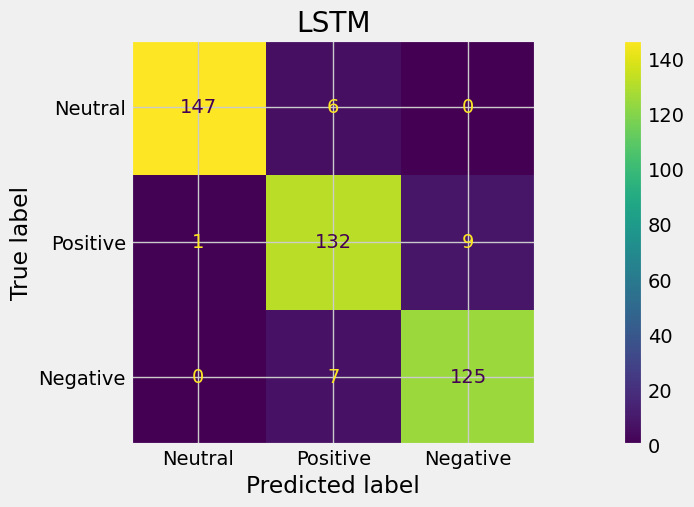

In [104]:
#Plotting Confusion matrix of Lstm Model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test1, pred1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plot_confmat2(cm,'viridis','LSTM')

In [40]:
names1 = ["Neutral","Positive","Negative"]

In [103]:
##trial function
# def plot_confmat(cm,color,heading):
#     plt.imshow(cm, cmap=color)
#     plt.colorbar()
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
#     plt.title(heading)
#     plt.xticks(np.arange(len(["Neutral","Positive","Negative"])), ["Neutral","Positive","Negative"])
#     plt.yticks(np.arange(len(["Neutral","Positive","Negative"])), ["Neutral","Positive","Negative"])
#     plt.title(heading)
#     plt.show()

In [95]:
def plot_confmat2(cm,color,heading):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Neutral","Positive","Negative"])
    disp = disp.plot(cmap=color,values_format='g')
    plt.title(heading)
    plt.show()


*		Classification Report GNB:
               precision    recall  f1-score   support

           0       0.65      0.97      0.78       153
           1       0.46      0.30      0.36       142
           2       0.81      0.66      0.73       132

    accuracy                           0.65       427
   macro avg       0.64      0.64      0.62       427
weighted avg       0.64      0.65      0.62       427



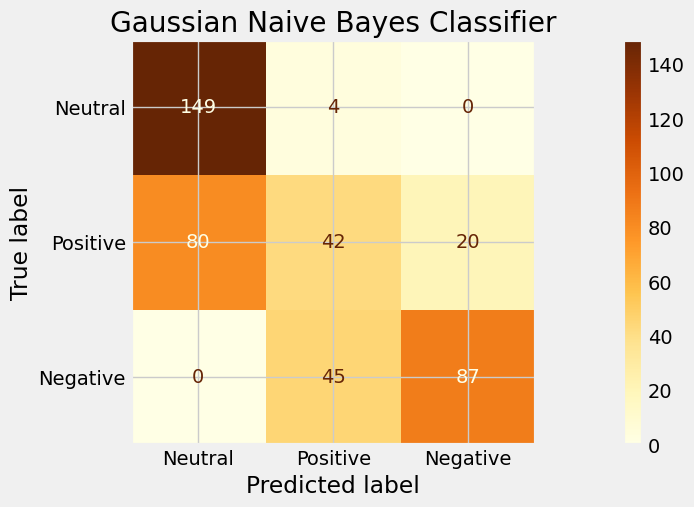

In [102]:
from sklearn.metrics import ConfusionMatrixDisplay
Classifier_gnb = GaussianNB().fit(x_train, np.argmax(y_train,axis=1))
pred_gnb = Classifier_gnb.predict(x_test)
title='Gaussian Naive Bayes Classifier'
print ('\n*\t\tClassification Report GNB:\n', classification_report(np.argmax(y_test,axis=1), pred_gnb))
cm = confusion_matrix(np.argmax(y_test,axis=1), pred_gnb)
plot_confmat2(cm,'YlOrBr',title)


*		Classification Report SVM:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       153
           1       0.98      0.89      0.94       142
           2       0.94      0.99      0.97       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



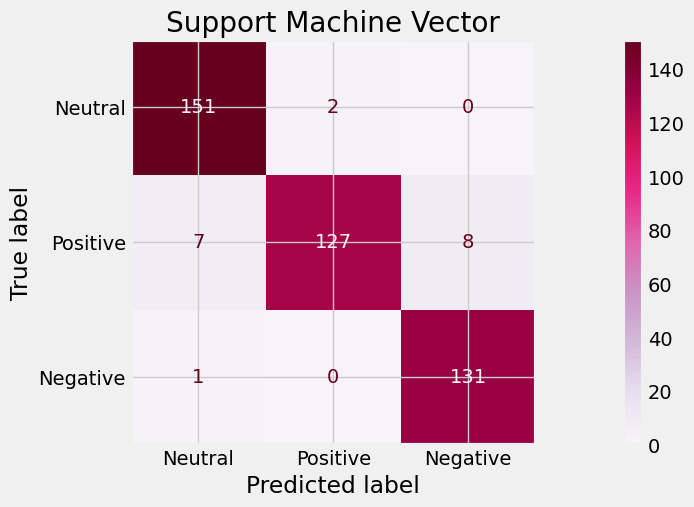

In [101]:
Classifier_svm = svm.SVC(kernel='linear').fit(x_train, np.argmax(y_train,axis=1))
pred_svm = Classifier_svm.predict(x_test)
title2='Support Machine Vector'
print ('\n*\t\tClassification Report SVM:\n', classification_report(np.argmax(y_test,axis=1), pred_svm))
cm2 = confusion_matrix(np.argmax(y_test,axis=1), pred_svm)
plot_confmat2(cm2,'PuRd',title2)


*		Classification Report LR:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       153
           1       0.99      0.94      0.96       142
           2       0.96      0.99      0.98       132

    accuracy                           0.97       427
   macro avg       0.97      0.97      0.97       427
weighted avg       0.97      0.97      0.97       427



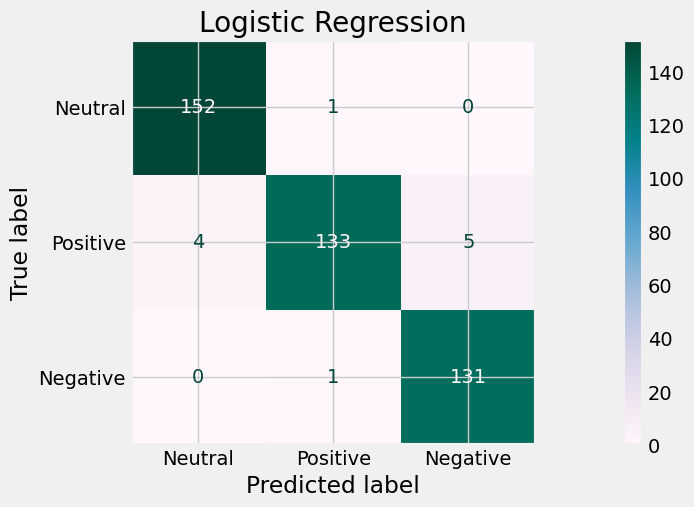

In [100]:
### Logistic Regression
Classifier_LR = linear_model.LogisticRegression(solver = 'liblinear', C = 75).fit(x_train, np.argmax(y_train,axis=1))
pred_LR = Classifier_LR.predict(x_test)
title3='Logistic Regression'
print ('\n*\t\tClassification Report LR:\n', classification_report(np.argmax(y_test,axis=1), pred_LR))
cm3 = confusion_matrix(np.argmax(y_test,axis=1), pred_LR)
plot_confmat2(cm3,'PuBuGn',title3)


*		Classification Report Random Forest:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       153
           1       0.94      0.94      0.94       142
           2       0.95      0.95      0.95       132

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



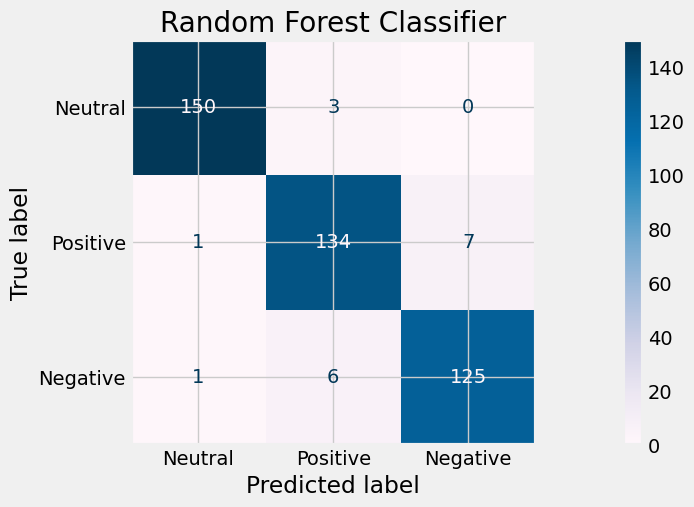

In [99]:
### Random Forest

Classifier_forest = RandomForestClassifier(n_estimators = 50, random_state = 0).fit(x_train,np.argmax(y_train,axis=1))
pred_fr = Classifier_dt.predict(x_test)
print ('\n*\t\tClassification Report Random Forest:\n', classification_report(np.argmax(y_test,axis=1), pred_fr))
title4='Random Forest Classifier'
cm4 = confusion_matrix(np.argmax(y_test,axis=1), pred_fr)
plot_confmat2(cm4,'PuBu',title4)

In [45]:
print('\n*\t\tClassification Report OF Brain Waves LSTM:\n', classification_report(np.argmax(y_test,axis=1), np.argmax(lstmmodel.predict(x_test),axis=1) ))

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step

*		Classification Report OF Brain Waves LSTM:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98       153
           1       0.91      0.93      0.92       142
           2       0.93      0.95      0.94       132

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427



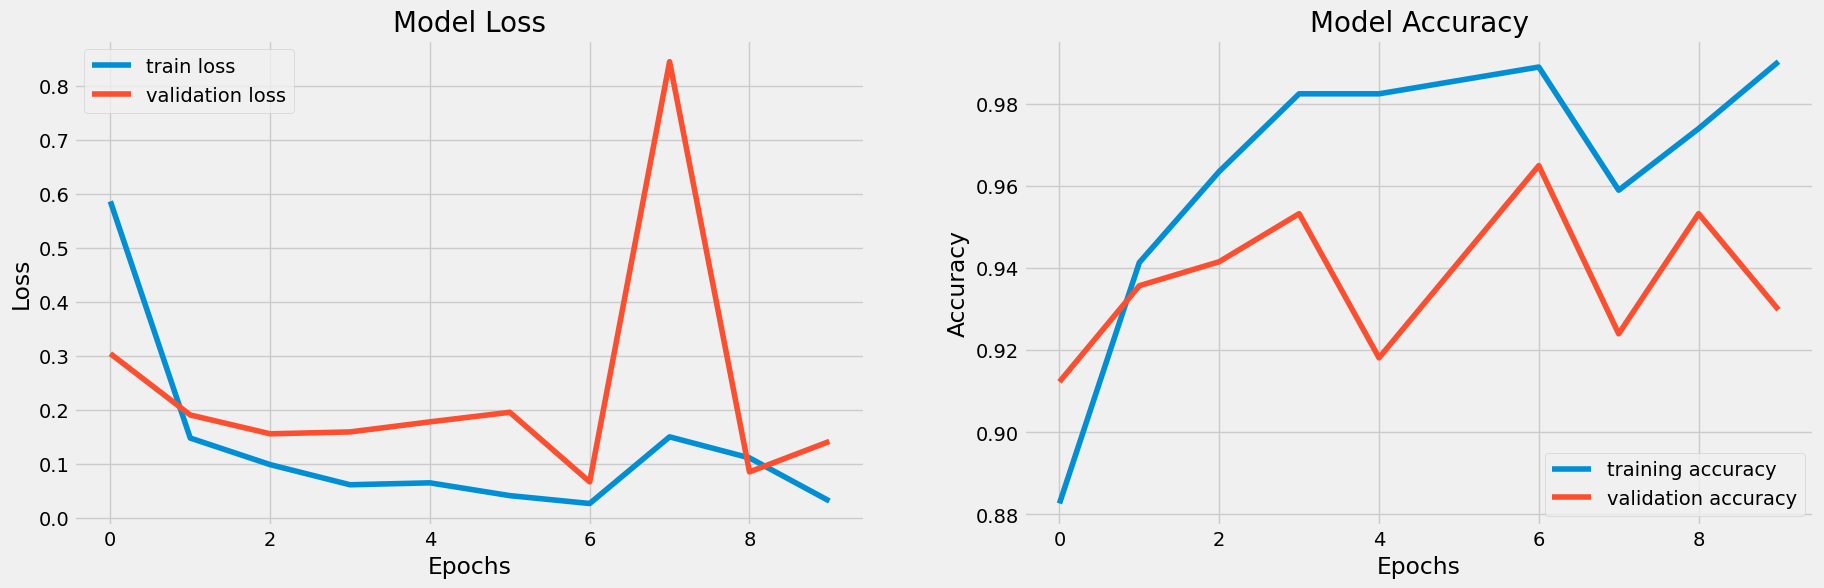

In [46]:
#Plotting Graph of Lstm model Training, Loss and Accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'validation loss'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()